# Assignment 2: Word2vec
_Word Representations and Language Models (WS 24/25)_

Group Members: Ludmila Bajuk, Buket Sak, Alexander Weyhe
***


For the second assignment, you will work with the Word2Vec model. 
* In the first part, your task is to train a Word2Vec model from scratch based on the news data we introduced in last exercise session, apply dimensionality reduction to the resulting embeddings, and plot word pairs similar to the analysis in the Word2Vec paper to reproduce their results.
* In the second part, you will implement a (relatively simple) word2vec model yourself and evaluate its performance.

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#FFF2CC;border-color:#D6B656;color:#856404">
<b>How to Submit the Assignment</b>

Please work on this assignment in groups of two or three. Make sure to add your names to this files header. After completion, share this assignment with me (<b>Julian Schelb - <a target="blank" href="https://www.kaggle.com/julianschelb">https://www.kaggle.com/julianschelb</a></b>) due Wednesday, 13th November, 12:00. Use the upper-right share button as instructed in the tutorial. In ILIAS, submit this notebook as response to Assignment 02.
</div>

In [14]:
# Packages for part 1
from gensim import utils
from sklearn.decomposition import PCA
from time import time  
import gensim.models
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import json

from tqdm import tqdm  # Use notebook mode for tqdm

# Initialize tqdm for pandas
tqdm.pandas()

# Packages for part 2
from scipy.spatial.distance import cosine
from sklearn import cluster
import plotly.express as px
from sklearn import preprocessing
import pandas as pd
import torch
import re

## Task 1: Pretrained Model

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load a pretrained Model</b> 
</div>

Download a pretrained Word2Vec model using the Gensim API. Select the model trained on the google news dataset with an embedding size of 300. You can find detailed instructions on using Gensim's GloVe model [here](https://radimrehurek.com/gensim/). Please note that downloading may take a few moments.


In [ ]:
# Load pretrained model using the gensim api
model = api.load("word2vec-google-news-300")

[==------------------------------------------------] 4.6% 76.7/1662.8MB downloaded

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Visualize Relations</b> 
</div>

Next, we ask you to reproduce [Figure 2 from the word vectors paper](https://proceedings.neurips.cc/paper_files/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf) by using the pretrained Word2Vec model. Please implement the following steps:

1. Retrieve word embeddings from the pretrained model for the country/capital word pairs indicated in list below.
2. Reduce the dimensionality of word embeddings: apply a principal component analysis (PCA) to reduce the dimensionality of the embeddings  to d = 2. Use the sklearn package here.
Plot the first two components as a scatterplot and connect both words of each word pair pairs by a line to indicate their relationship.
3. Discuss your results.

In [15]:
# Pre-defined list of word pairs
countries_capitals = [('china', 'beijing'),('russia', 'moscow'),('japan', 'tokyo'),
                      ('poland', 'warsaw'),('germany', 'berlin'),('france','paris'),
                      ('italy', 'rome'), ('greece', 'athens'),('spain', 'madrid')]

In [16]:
# Get word embeddings for words in countries_capitals list and apply PCA

def getWordPairEmbeddings(word_pairs, model):
    """Use Word2vec to obtain word embeddings."""
    # Remove tuples when one word is not in the model.
    for words in word_pairs:
        if words[0] not in model or words[1] not in model:
            word_pairs.remove(words)
            
    word_embeddings = []
    
    for word1, word2 in word_pairs:
        word_embeddings.append(model[word1])
        word_embeddings.append(model[word2])
    
    return word_embeddings

In [17]:
def reduceDimensionality(embeddings, n = 2): 
    """Reduce the dimensionality of embeddings (e.g. for plotting)"""
    pca = PCA(n_components=n)
    
    new_embeddings = pca.fit_transform(embeddings)
    return new_embeddings

In [18]:
# Plot first two components as scatterplot and connect word pairs by line

def plotWordPair(embeddings, word_pairs):
    """ Plots relations of word pairs"""
    words = [word for pair in word_pairs for word in pair]
    
    plt.figure(figsize=(10, 8))

    # Plot each word
    for i, (x, y) in enumerate(embeddings):
        plt.scatter(x, y)
        plt.text(x + 0.02, y + 0.02, words[i], fontsize=12)

    # Draw lines between each pair
    for i in range(0, len(embeddings), 2):
        x_values = [embeddings[i][0], embeddings[i+1][0]]
        y_values = [embeddings[i][1], embeddings[i+1][1]]
        plt.plot(x_values, y_values, 'k--') 

    plt.title("Word Pair Relations")
    plt.show()

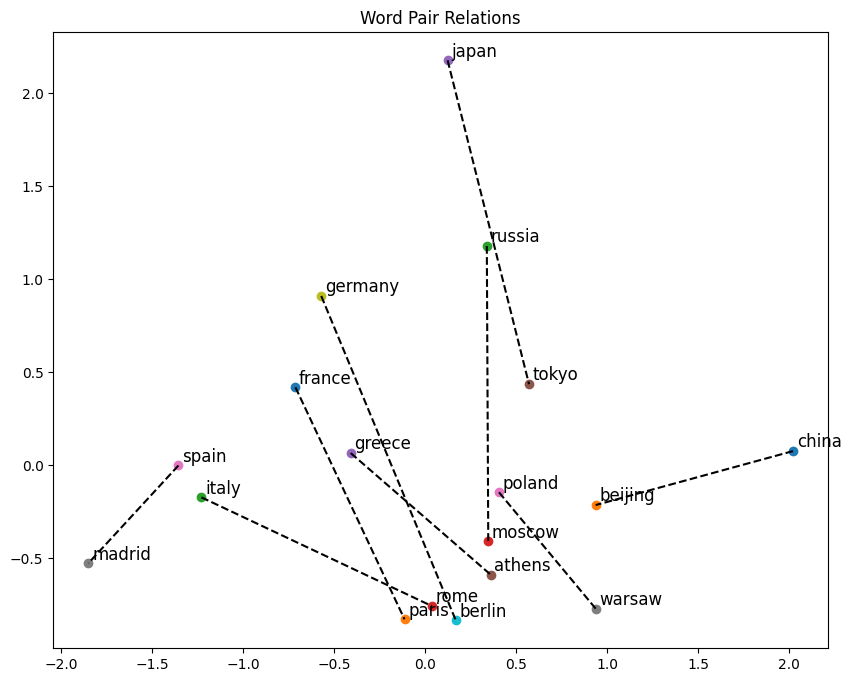

In [19]:
# Obtain embeddings, apply PCA and plot word pair relations

# Obtain embeddigns
embeddings_countries_cap = getWordPairEmbeddings(countries_capitals, model)

# Apply PCA
new_embeddings_countries_cap = reduceDimensionality(embeddings_countries_cap)

# Plot word pair relation
plotWordPair(new_embeddings_countries_cap, countries_capitals)

**Discuss your results:**

Countries consistently appear above their corresponding capitals, suggesting that the model captures the country-capital relationship in a somewhat systematic manner. However, the varying distances between countries and capitals indicate that the model does not capture this relationship very effectively.

In analogy to the previous visualisation, plot PCA-reduced embeddings (first two components) of for the embeddings corresponding to the following list of 
Countries/Heads of State and discuss your results.

In [20]:
# Pre-defined list of word pairs
countries_HoS = [('china', 'ping'),('russia', 'putin'),('turkey', 'erdogan'),
         ('germany', 'merkel'),('france','macron')]

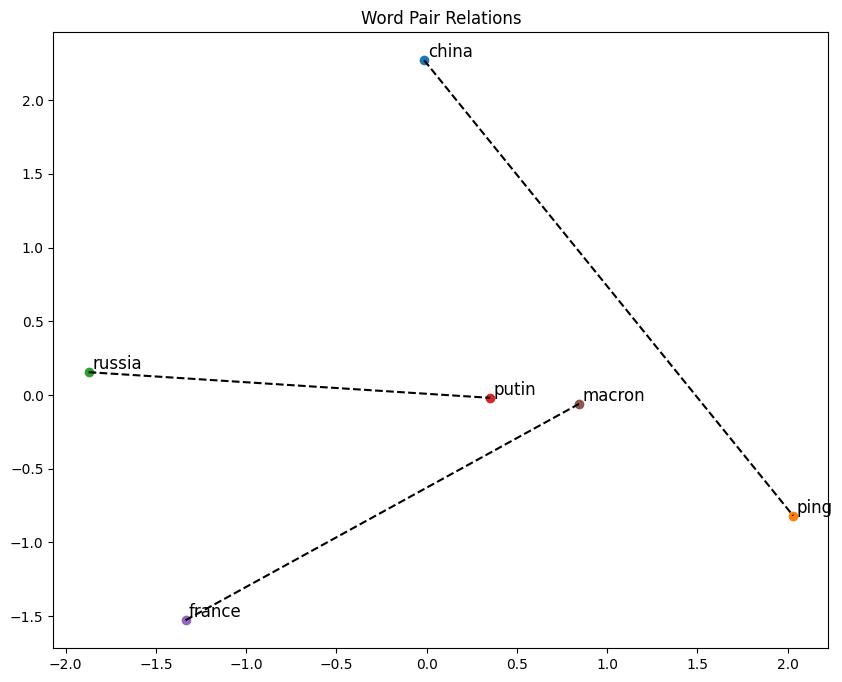

In [22]:
# Obtain embeddings, apply PCA and plot word pair relations

# Obtain embeddigns
embeddings_HoS = getWordPairEmbeddings(countries_HoS, model)

# Apply PCA
new_embeddings_HoS = reduceDimensionality(embeddings_HoS)

# Plot word pair relation
plotWordPair(new_embeddings_HoS, countries_HoS)

**Discuss your results:**

For countries and their heads of state, we can conclude that the model fails to capture the relationship between them. Unlike the country-capital pairs, where there is at least a systematic pattern in the positioning, the lack of structure here suggests that the model could not establish a meaningful connection between countries and their leaders.

***

## Task 2: Train a Word2vec Model

In this task, you will implement a simplified Word2Vec model from scratch using PyTorch, gaining hands-on experience with its core concepts and exploring how word embeddings capture semantic relationships.

**Here are some helpful resources:**

* https://muhark.github.io/python/ml/nlp/2021/10/21/word2vec-from-scratch.html
* https://otmaneboughaba.com/posts/Word2Vec-in-Pytorch/
* https://rguigoures.github.io/word2vec_pytorch/
* https://github.com/Andras7/word2vec-pytorch
* https://pytorch.org/tutorials/

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load the Dataset</b> 
</div>

First, you need to add [this](https://www.kaggle.com/datasets/julianschelb/newsdata) news dataset to your notebook. Click on "+Add data" and the dataset. In the next step, please implement the following steps to load the data and pre-process it:

* Use the provided code snippet to load the data.
* Iterate over the articles, remove all line breaks ("\n"), and store every article's text in a list.

In [24]:
# Read JSON file with article data 
with open("../input/relevant_articles.json","rb") as d:
    relevant_articles = json.load(d)

# Convert the JSON file into a DataFrame
df = pd.DataFrame(relevant_articles)

# Have a peek
df.head()

,_id,url,title,feed,type,pub,ret,lang,refs,sum,body,text,auth
0,197727,http://www.theguardian.com/housing-network/201...,Five steps to fixing the UK housing crisis in ...,guardian,politics,{'$date': '2016-01-01T09:12:27.000+0000'},{'$date': '2016-01-01T09:27:32.000+0000'},en,[http://www.theguardian.com/commentisfree/2015...,Headlines about the utter madness of our housi...,Perhaps in years to come 2015 will be remember...,Headlines about the utter madness of our housi...,NaN
1,197728,http://www.theguardian.com/commentisfree/2016/...,That’s enough assessments of 2015. It’s time t...,guardian,politics,{'$date': '2016-01-01T09:37:06.000+0000'},{'$date': '2016-01-01T09:47:42.000+0000'},en,"[http://www.theguardian.com/business/davos, ht...",From Strictly Come Dancing featuring Vladimir ...,• Jeremy Corbyn turns down invitation to atten...,From Strictly Come Dancing featuring Vladimir ...,NaN
2,197995,http://www.theguardian.com/politics/2016/jan/0...,The paperback memoirs of Miss Rice-Davies : ar...,guardian,politics,{'$date': '2016-01-01T05:00:22.000+0000'},{'$date': '2016-01-01T22:59:09.000+0000'},en,[http://www.theguardian.com/politics/2014/dec/...,1 January 1964 : The Mandy Report turns out to...,"Miss Mandy Rice-Davies, one of 1963’s better k...",1 January 1964 : The Mandy Report turns out to...,NaN
3,198038,http://www.bbc.co.uk/news/uk-scotland-35210821...,'Very drunk' patient numbers revealed,bbc,politics,{'$date': '2016-01-02T00:42:46.000+0000'},{'$date': '2016-01-02T00:45:47.000+0000'},en,[http://www.bbc.co.uk/news/uk-scotland-35097230],Ambulances attend more than 60 incidents on av...,"Paramedics treated about 12,000 people who wer...",Ambulances attend more than 60 incidents on av...,NaN
4,198046,http://www.bbc.co.uk/news/uk-35212696#sa-ns_mc...,Littering fines set to rise to £150,bbc,politics,{'$date': '2016-01-02T04:28:41.000+0000'},{'$date': '2016-01-02T04:47:52.000+0000'},en,[http://www.telegraph.co.uk/news/politics/1206...,Penalties for people who drop litter could rea...,"According to the Daily Telegraph, the minimum ...",Penalties for people who drop litter could rea...,NaN


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Data Preparation and Tokenization</b> 
</div>

In this step, preprocess the "text" column from the previously loaded news dataset to prepare it for Word2Vec training. Implement the following steps:

1. **Select Articles**: Choose the first 20,000 articles to manage memory usage and training time.

2. **Clean the Text**: Remove non-alphanumeric characters (e.g., newline characters, punctuation, extra spaces) and convert the text to lowercase. Additionally, remove numbers and common stopwords (e.g., "the", "and", "is") to reduce vocabulary size.

3. **Tokenize the Text**: Split the cleaned text into individual words, which will serve as context and target words during training. **Example**: `"Word2Vec learns word embeddings."` becomes `["word2vec", "learns", "word", "embeddings"]`.

4. **Compile List of Tokens**: Create a list of all tokens (words), which will be used to build the vocabulary and train the Word2Vec model in later steps.

In [26]:
# Select the first 20000 articles
df_2 = df[:20000]

# Preprocess text
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk import word_tokenize

def preprocess(text):
    # Remove non-alphanumeric characters, numbers and punctuation.
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # Remove new lines.
    text = text.replace('\n', '')
    
    # Remove extra spaces.
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenize.
    text = word_tokenize(text)
    
    # Remove stopwords.
    text_preprocessed = [w.lower() for w in text if w.lower() not in stop_words]
    
    return text_preprocessed

list_of_tokens = df_2["text"].apply(preprocess)

In [27]:
# Create a list with all tokens in the data

all_tokens = [item for sublist in list_of_tokens for item in sublist]
len(all_tokens)

7126811

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Build the Vocabulary</b>
</div>

Now construct the vocabulary for your Word2Vec model by completing the `Vocabulary` class. Implement the following functionality:

1. **Frequency Threshold**: Add a frequency threshold `n` (e.g., 25) to filter out rare words that add noise but little value to training. Ensure only words appearing more than `n` times are kept in the vocabulary.

2. **Mappings**: Create dictionaries to map each word in the vocabulary to a unique ID and vice versa. Implement functions to convert tokens to token IDs and back.

    - Example `word_to_id` dictionary: `{"learning": 0, "model": 1, ...}`
    - Example `id_to_word` dictionary: `{0: "learning", 1: "model", ...}`

<br>

3. **Vocabulary Size**: Implement a method to display the size of the filtered vocabulary.

In [28]:
from collections import Counter

class Vocabulary:
    def __init__(self, tokens, frequency_threshold=25):
        """Initialize the Vocabulary class."""
        self.tokens = tokens
        self.frequency_threshold = frequency_threshold
        self.word_to_id = dict()
        self.id_to_word = dict()
        self.build_vocabulary()
        
    def build_vocabulary(self):
        """Build the vocabulary and mappings."""
        # Returns a frequency dictionary with elements as key and counts as values.
        frequency_tokens = Counter(self.tokens)
        
        index = 0
        
        for word, frequency in frequency_tokens.items():
            if frequency > self.frequency_threshold:
                self.word_to_id[word] = index
                self.id_to_word[index] = word
                index += 1
                
        # After we assigned each frequent word an unique index, we create a new entry in the dictionary for unknown words and assign it the
        # current index. 
        self.word_to_id['<UNK>'] = index
        self.id_to_word[index] = '<UNK>'
        
        print(f"Vocabulary size after filtering: {len(self)}")

    def convert_token_to_id(self, token):
        """Convert a single token to its ID."""
        
        # This returns the uniqie index of the token, or the index for unknown words if the word is not in the vocabulary.
        return self.word_to_id.get(token, self.word_to_id['<UNK>'])

    def convert_id_to_token(self, id_):
        """Convert a single ID back to its token."""
        
        # This works similar as the convert_token_to_id.
        return self.id_to_word.get(id_, '<UNK>')

    def convert_tokens_to_ids(self, tokens):
        """Convert a list of tokens to their IDs."""
        
        # This list comprehension iterates through the given list of tokens and looks up the corresponding index. We look up the token by calling
        # the previously created function convert_token_to_id.
        return [self.convert_token_to_id(token) for token in tokens]

    def convert_ids_to_tokens(self, ids):
        """Convert a list of IDs to their tokens."""
        
        # This works similar as the convert_tokens_to_ids.
        return [self.convert_id_to_token(id_) for id_ in ids]

    def __len__(self):
        """Return the vocabulary size, including <UNK>."""
        
        # Finally, we can return the length of the entire vocabulary by taking the lenght of word_to_id (could also work with id_to_word).
        return len(self.word_to_id)

In [29]:
# Create the vocabulary
vocab = Vocabulary(all_tokens)

Vocabulary size after filtering: 17202


In [30]:
# Test your implementation:
# Convert a list of tokens to their corresponding IDs
search_words = set([word for pair in countries_HoS + countries_capitals for word in pair])
ids = vocab.convert_tokens_to_ids(search_words)
print(f"IDs for tokens: {ids}")

# Convert a list of IDs back to their corresponding tokens
tokens_back = vocab.convert_ids_to_tokens(ids)
print(f"Tokens for IDs: {tokens_back}")

# Check the vocabulary size
print(f"Vocabulary size: {len(vocab)}")

IDs for tokens: [1424, 4634, 17201, 349, 2081, 7706, 4797, 7059, 7053, 12899, 3350, 8831, 13725, 15886, 328, 1920, 4640, 7696, 4741, 8298, 301]
Tokens for IDs: ['china', 'rome', '<UNK>', 'tokyo', 'greece', 'moscow', 'spain', 'warsaw', 'poland', 'athens', 'germany', 'beijing', 'madrid', 'macron', 'russia', 'paris', 'france', 'japan', 'berlin', 'italy', 'putin']
Vocabulary size: 17202


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 4: Compile Training Dataset</b>
</div>

In this step, you’ll compile the training dataset by creating target-context word pairs and converting them to a format suitable for training.

1. **Generate Target-Context Pairs and Store in DataFrame**: For each word (center or "target" word) in the text, identify its surrounding words ("context" words) within a specified window size. For example, with a window size of 2, each target word will have up to two words to its left and two to its right as its context words. Store these target-context pairs in a DataFrame with two columns, `target` and `context`, representing each word pair.

    - **Example**: Given the sentence `"Deep learning is a subset of machine learning methods"` the target-context pairs with a window size of 2 would look like:

      ```
      [('deep', 'learning'),
       ('deep', 'subset'),
       ('learning', 'deep'),
       ('learning', 'subset'),
       ('learning', 'machine'),
       ('subset', 'deep'),
       ('subset', 'learning'),
       ('subset', 'machine'), ...]
      ```
<br>

2. **Complete the PyTorch Dataset Class**: Use the `Dataset` class template provided below and complete it to store the DataFrame in a format ready for training. The class should return a encoded target word and its corresponding context word for each pair. See here for more information about PyTorch datasets: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

3. **Create a DataLoader**: After defining the dataset, wrap it into a DataLoader with a batch size of 64. This allows efficient batching during training and enables the model to process multiple samples in parallel. See here for more information about PyTorch dataloaders https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [31]:
# Create Dataframe with target - context pairs
pairs = []
for i, target_word in enumerate(all_tokens):
    start = max(0, i - 2)
    end = min(len(all_tokens), i + 2 + 1)
    
    # Making sure the target word is in our vocabulary.
    if target_word in vocab.word_to_id.keys():
        for j in range(start, end):
            if j != i: 
                context_word = all_tokens[j]
                # Making sure the context word is in our vocabulary.
                if context_word in vocab.word_to_id.keys():
                    pairs.append((target_word, context_word))

In [32]:
# Create dataframe
df_target_context = pd.DataFrame(pairs, columns=["Target", "Context"])
df_target_context

,Target,Context
0,headlines,utter
1,headlines,madness
2,utter,headlines
3,utter,madness
4,utter,housing
...,...,...
23814851,usget,religion
23814852,usget,entering
23814853,usget,newsletter
23814854,newsletter,entering


In [33]:
from torch.utils.data import Dataset

class W2VDataset(Dataset):
    def __init__(self, df, vocab):
        """Initialize the dataset with a DataFrame and Vocabulary instance."""
        self.df = df
        self.vocab = vocab

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.df)

    def __getitem__(self, idx):
        """Retrieve the context and target word IDs for the given index."""
        target = self.vocab.convert_token_to_id(self.df["Target"].iloc[idx])
        context = self.vocab.convert_token_to_id(self.df["Context"].iloc[idx])
        
        return target, context

dataset = W2VDataset(df_target_context, vocab)
dataset.__getitem__(0)

(0, 1)

In [34]:
# Define a DataLoader using the dataset instance
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset=dataset, batch_size=64, shuffle=True)

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 5: Build the Model</b> 
</div>

In this step, you will complete the implementation of a Word2Vec model in PyTorch. The model will consist of an embedding layer to represent words as dense vectors and a linear layer to predict context words from each target word embedding. You can read more about defining models in PyTorch here: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

1. **Define the Model Structure**: Complete the `Word2Vec` class by inheriting from `torch.nn.Module`. In the `__init__` method:
   - Initialize an embedding layer with dimensions `vocab_size × embed_size`, where `vocab_size` is the number of unique words, and `embed_size` is the desired embedding dimension.
   - Add a linear layer that maps the embedding dimension back to `vocab_size`, which will be used to predict words.

2. **Define the Forward Pass**: Implement the `forward` method to perform an embedding lookup using the input tensor `x` (word ID), then apply the linear layer to output predictions for the context words.

In [35]:
import torch

class Word2Vec(torch.nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Word2Vec, self).__init__()
        
        # Creating an embedding layer.
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        
        # Creating the linear layer.
        self.linear = torch.nn.Linear(in_features=embed_size, out_features=vocab_size)

    # Passes the data through the model.
    def forward(self, x):
        
        # First we give the input into the embedding layer.
        embedding = self.embedding_layer(x)
        
        # We then give it to the linear layer and return the output.
        return self.linear(embedding)

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 6: Train the Model</b>
</div>

In this step, train the Word2Vec model to learn meaningful word embeddings from the dataset. For this example, use an embedding size of 200, though the original Word2Vec paper used a larger embedding size of 300.

1. **Review Hyperparameter Choices**: We have set initial hyperparameter values, including cross-entropy loss to measure differences between predicted word probabilities and actual context words, and the Adam optimizer with a learning rate of 0.01. Review these parameters and understand how they impact training. Adjust them if needed to improve performance.

2. **Training Loop**: Train the model across multiple epochs, processing the target-context pairs in batches:
   - For each batch, ensure both the context and target tensors are moved to the device (CPU or GPU).
   - Compute predictions and calculate the loss.
   - Backpropagate to adjust the weights and optimize the model parameters.
   - Track and print the loss after each epoch to monitor training progress.

For more information on loss functions, optimizers, and implementing training loops in PyTorch, refer to the following resources:

- [Training with PyTorch — PyTorch Tutorials 2.5.0 + documentation](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [Training a Model in PyTorch - Deep Learning University](https://deeplearninguniversity.com/pytorch/training-a-model-in-pytorch/)
- [Creating a Training Loop for PyTorch Models](https://machinelearningmastery.com/creating-a-training-loop-for-pytorch-models/)

In [36]:
from torch import nn

# Hyperparameter
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBED_SIZE = 200
VOCAB_SIZE = len(vocab)
EPOCHS = 4
LR = 0.01

# Instantiate the model
model = Word2Vec(VOCAB_SIZE, EMBED_SIZE)
model.to(DEVICE)

# Instantiate loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [37]:
# Model architecture
print(model)

Word2Vec(
  (embedding_layer): Embedding(17202, 200)
  (linear): Linear(in_features=200, out_features=17202, bias=True)
)


In [38]:
loss_values = []

# Outer loop for epochs with tqdm progress bar
for epoch in range(EPOCHS):
    running_loss = 0.0

    # Inner loop for batches with tqdm progress bar
    for batch, (context, target) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch + 1}", leave=False)):
        context = context.to(DEVICE)
        target = target.to(DEVICE).long()
        
        # Saving the predicted output.
        prediction = model(target)
        
        # Computing the loss between the prediction and ground truth.
        loss = loss_fn(prediction, context)
        
        # Get gradients.
        loss.backward()
        
        # Update the weights of the model.
        optimizer.step()
        
        # Get rid of the gradients.
        optimizer.zero_grad()
        
        # Computing the running loss.
        running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {epoch_loss}")
    loss_values.append(epoch_loss)

Epoch [1/4], Loss: 9.184527317771321


Epoch [2/4], Loss: 9.131530834229501


Epoch [3/4], Loss: 9.131951837759466


Epoch [4/4], Loss: 9.132232504935013


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 7: Use the Model</b> 
</div>

Now that your Word2Vec model is trained, you’ll use it to analyze word relationships and visualize word embeddings.

1. **Replicate Visualization from Task 1**: Access the learned word embeddings directly from the weights of the embedding layer. You can do this by retrieving the weights from the model, such as with `model.embedding.weight.detach().cpu()`, to obtain the learned embedding vectors. Use these embeddings to replicate the visualization from Task 1.

2. **Retrieve Similar Words**: For each entity (head of state, capital, ...), retrieve the 5 most similar words by evaluating the output probabilities from the model:
   - Pass the word ID (e.g., `model(word_id)`) to generate predictions, which represent probabilities of context words.
   - Identify the words with the highest probabilities in the output layer; these correspond to the words most likely to appear in similar contexts. Convert the ids back to words using the mappings we created earlier.


In [42]:
# Print 5 most similar words
def find_similar_words(word, top_n=5):
    try:
        word_id = vocab.word_to_id[word]
        word_vector = model.embedding_layer.weight[word_id].detach().cpu()  # Retrieve word embedding
    
        # Compute cosine similarities between this word and all other words
        cosine_similarities = torch.nn.functional.cosine_similarity(word_vector, model.embedding_layer.weight.detach().cpu(), dim=1)
        similar_ids = torch.topk(cosine_similarities, top_n + 1).indices.tolist()  # +1 to ignore the word itself

        # Retrieve and print the top N similar words
        similar_words = [vocab.id_to_word[idx] for idx in similar_ids if idx != word_id][:top_n]
        print(f"Words most similar to '{word}': {similar_words}")
        return similar_words
    except:
        return f"{word} not in vocabulray."


for word1, word2 in countries_HoS:
    print(find_similar_words(word1))
    print(find_similar_words(word2))

Words most similar to 'china': ['largest', 'felt', 'eus', 'tightening', 'lifelong']
['largest', 'felt', 'eus', 'tightening', 'lifelong']
ping not in vocabulray.
Words most similar to 'russia': ['characteristic', 'european', 'indeed', 'bedfordshire', 'eastern']
['characteristic', 'european', 'indeed', 'bedfordshire', 'eastern']
Words most similar to 'putin': ['traveled', 'comment', 'hargreaves', 'graphic', 'served']
['traveled', 'comment', 'hargreaves', 'graphic', 'served']
Words most similar to 'france': ['reiterated', 'formidable', 'euhowever', 'exposing', 'interests']
['reiterated', 'formidable', 'euhowever', 'exposing', 'interests']
Words most similar to 'macron': ['renee', 'lie', 'garcia', 'nra', 'followup']
['renee', 'lie', 'garcia', 'nra', 'followup']


In [ ]:
# Obtain embeddings, apply PCA and plot word pair relations

# Retrieve word embeddings from the model's embedding layer
embeddings = model.embedding_layer.weight.detach().cpu().numpy()  # Shape: (vocab_size, embed_size)

# Perform PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plotting a subset of words (you can select specific words or visualize a sample)
plt.figure(figsize=(10, 8))
words_to_plot = list(vocab.word_to_id.keys())[:100]  # Adjust as needed

for word in words_to_plot:
    idx = vocab.word_to_id[word]
    x, y = embeddings_2d[idx]
    plt.scatter(x, y, color='blue')
    plt.text(x, y, word, fontsize=9)

plt.xlabel("PCA Component 1")

plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection of Word2Vec Embeddings")
plt.show()

**Discuss your results:**

The plot suggests that the model starts grouping similar words together. However, the majority of words is clustered in the center with a few words outside of this cluster. Additionally, looking at the most similar words, the model does not output expected similar words for the most part as well as non-existing words (which are probably leftovers from the preprocessing). 